In [1]:
import numpy as np

import matplotlib.pyplot as plt
from timeit import default_timer as timer

plt.rcParams['figure.figsize'] = [20, 7]
plt.rcParams['font.size'] = 15
plt.rcParams['savefig.format'] = "png"
plt.rcParams["figure.autolayout"] = True

## Stationary Iterative Solvers

In [2]:
def Jacobi(A, x, b, iter=1000, omega=1.0, config = { "func_iter" : None }):
    L, D, U = np.triu(A, k=1), np.diag(np.diag(A, k=0)), np.tril(A, k=-1)
    D_inv = np.diag(1.0 / np.diag(D))

    r = b - A @ x
    res = np.inner(r, r)

    if config["func_iter"]:
        config["func_iter"](0, x, r, res)

    for i in range(1, iter):
        r = b - A @ x
        x = x + omega * D_inv @ r
        res = np.inner(r, r)

        if config["func_iter"]:
            config["func_iter"](iter, x, r, res)

    return x

## Multigrid Solver

In [3]:
def restrict_mat(size, dim):
    size = int(size) if dim == 1 else int(np.sqrt(size))

    R = np.zeros((int(size/2), size))
    R.flat[0:R.size:size+2] = (1.0/4.0) * 1
    R.flat[1:R.size:size+2] = (1.0/4.0) * 2
    R.flat[2:R.size:size+2] = (1.0/4.0) * 1

    if dim == 2:
        R = np.kron(R, R)

    return R

In [4]:
def prolongate_mat(size, dim):
    R = restrict_mat(size, dim)

    return (2.0 * R.T) if dim == 1 else (4.0 * R.T)

In [5]:
def mu_cycle(A, v, f, mu, depth, dim, solver):
    if dim not in [1, 2]:
        raise ValueError("> 2 dimensions not implemented")

    if depth == 0 or len(v) == 1:
        u = np.linalg.inv(A) @ f
        return u

    u = solver(A, v, f)
    r = f - A @ u
    
    R = restrict_mat(len(v), dim)
    I = prolongate_mat(len(v), dim)

    A_2h = R @ A @ I
    r_2h = R @ r
    e_2h = np.zeros(len(r_2h))
    for _ in range(0, mu):
        e_2h = mu_cycle(A_2h, e_2h, r_2h, mu, depth - 1, dim, solver)

    u += I @ e_2h
    u = solver(A, u, f)

    return u

def Multigrid(A, x, b, mu, iterations, config = {"solver" : Jacobi, "depth" : np.inf, "dimension" : 1, "func_iter" : None}):
    r = b - A @ x
    res = np.inner(r, r)

    if config["func_iter"]:
        config["func_iter"](x, r, res)

    while res > 1e-8 and iterations > 0:
        x = mu_cycle(A, x, b, mu, config["depth"], config["dimension"], config["solver"])
        r = b - A @ x
        res = np.inner(r, r)
        iterations -= 1

        if config["func_iter"]:
            config["func_iter"](x, r, res)
    
    return x

## Example 1: 1D Poisson equation

In [6]:
sigma = 0
lower = 0.0
upper = 1.0

L = upper - lower
N = 2**5 + 1
h = L/N
n = N - 2
fourier_modes = lambda j, k, n: np.sin( j*k*np.pi / n )

# Discretization Matrix
b = np.ones(n - 1) * -1.0
a = np.ones(n) * (2.0 + sigma*h**2)
A = np.diag(b, -1) + np.diag(b, 1) + np.diag(a, 0)
A = -A

# initial guess
num = np.arange(N)
v = (1.0/3.0) * (fourier_modes(num, 1, N - 1) + fourier_modes(num, 6, N - 1) + fourier_modes(num, 32, N - 1))
x = np.linspace(0.0, 1.0, N)

# rh side
f = np.zeros(n)

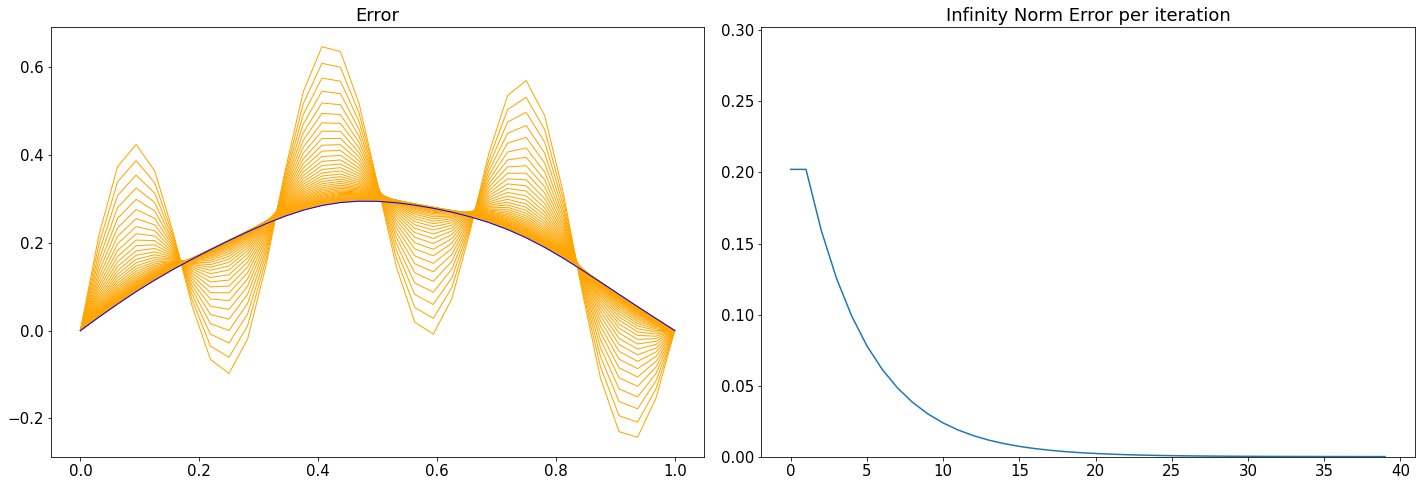

In [7]:
error = []

fig, (ax1, ax2) = plt.subplots(1, 2)

def plot_progress(i, u, r, res):
    ax1.plot(x, np.concatenate([ [v[0]], u, [v[-1]] ]), color="orange", linewidth=1)
    error.append(res)#np.linalg.norm(-u, np.inf))


_v = v.copy()
u = _v[1:-1].copy()
_v[1:-1] = Jacobi(A, u, f, 40, 2.0/3.0, config={ "func_iter" : plot_progress});


ax1.set_title("Error")
ax1.plot(x, _v, color="blue",  linewidth=1)

ax2.set_title("Infinity Norm Error per iteration")
ax2.set_ylim(0.0, np.max(error) + 0.1)
ax2.plot(np.arange(0, len(error)), error);

## Example 2: 2D Poisson equation

In [8]:
sigma = 0
lower = 0.0
upper = 1.0

L = upper - lower
N = 2*10 + 1
h = L/N
n = N - 2
fourier_modes = lambda i, j, k, n: np.sin( i*k*np.pi / n ) * np.sin( j*k*np.pi / n )

# Discretization Matrix
A = np.kron(np.diag(np.ones(n - 1), -1) + np.diag(np.ones(n - 1), 1), -np.eye(n))
D = -1.0 * np.diag(np.ones(n-1), -1) + -1.0 * np.diag(np.ones(n-1), 1) + 4 * np.diag(np.ones(n), 0)
A += np.kron(np.diag(np.ones(n), 0), D)

numX, numY = np.meshgrid(np.arange(N), np.arange(N))

# initial guess
v = (1.0 / 3.0) * (fourier_modes(numX, numY, 1, N-1) + fourier_modes(numX, numY, 6, N-1) + fourier_modes(numX, numY, 32, N-1))

# rh side
f = np.random.rand( n**2 ) # * h**2 #np.zeros(n**2)

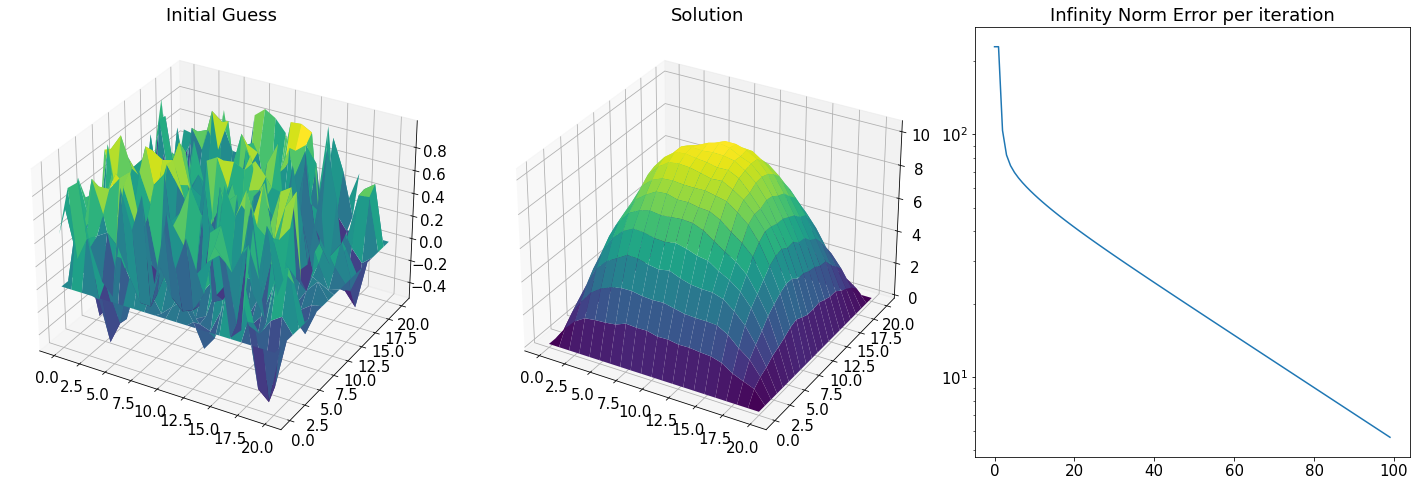

In [9]:
error_j = []
def plot_progress(i, u, r, res):
    error_j.append(res)

fig = plt.figure()
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_title("Initial Guess")
ax.plot_surface(numX, numY, v, cmap='viridis', edgecolor='none')
_numX, _numY = np.meshgrid(np.arange(n), np.arange(n))
ax.plot_surface(_numX, _numY, f.reshape(n, n), cmap='viridis', edgecolor='none')


_v = v.copy()
u = _v[1:-1, 1:-1].flatten().copy()
u = Jacobi(A, u, f, 100, config={ "func_iter" : plot_progress})
_v[1:-1, 1:-1] = u.reshape(n, n)

ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_title("Solution")
ax.plot_surface(numX, numY, _v, cmap='viridis', edgecolor='none')

ax = fig.add_subplot(1, 3, 3)
ax.set_title("Infinity Norm Error per iteration")
ax.set_yscale("log")
ax.plot(np.arange(0, len(error_j)), error_j);

# Example 3: Steady State Heat Equation

In [10]:
lower = 0.0
upper = 1.0

L = upper - lower
N = 2**5 + 1
h = L/N
n = N - 2
fourier_modes = lambda i, j, k, n: np.sin( i*k*np.pi / n ) * np.sin( j*k*np.pi / n )

# Discretization Matrix
A = np.kron(np.diag(np.ones(n - 1), -1) + np.diag(np.ones(n - 1), 1), -np.eye(n))
D = -1.0 * np.diag(np.ones(n-1), -1) + -1.0 * np.diag(np.ones(n-1), 1) + 4 * np.diag(np.ones(n), 0)
A += np.kron(np.diag(np.ones(n), 0), D)

numX, numY = np.meshgrid(np.arange(N), np.arange(N))

# initial guess
v = (1.0 / 3.0) * (fourier_modes(numX, numY, 1, N-1))
v[::, 0] = 10.0 
v[::, -1] = 0.0
v[0, ::] = 0.0 
v[-1, ::] = 0.0

# rh side
f = np.zeros((n, n))
f[::, 0] += v[1:-1, 0]
f[::, -1] += v[1:-1, -1]
f[0, ::] += v[0, 1:-1]
f[-1, ::] += v[-1, 1:-1]
f = f.flatten()

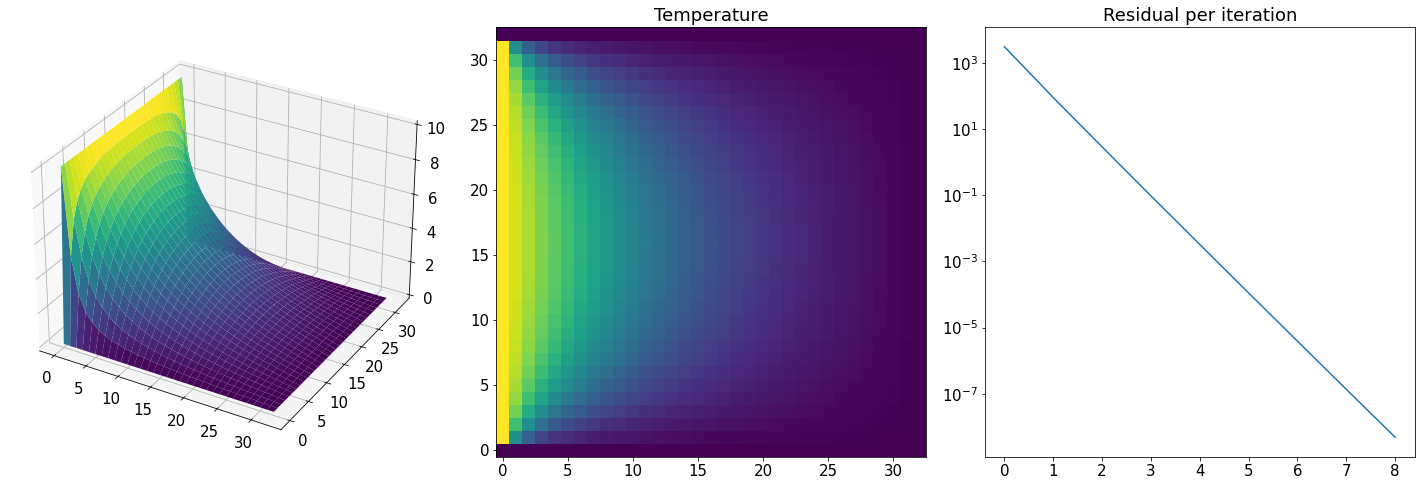

In [11]:
error_mg = []
def plot_progress(u, r, res):
    error_mg.append(res)

def heatmap2d(arr: np.ndarray):
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()

_v = v.copy()
u = _v[1:-1, 1:-1].flatten().copy()
u = Multigrid(A, u, f, 1, 1000, config={ "solver" : lambda A, x, b: Jacobi(A, x, b, 3, 2/3), "dimension" : 2, "depth" : 100, "func_iter" : plot_progress})
_v[1:-1, 1:-1] = u.reshape(n, n)

fig = plt.figure()
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.plot_surface(numX, numY, _v, cmap='viridis', edgecolor='none')

ax = fig.add_subplot(1, 3, 2)
ax.set_title("Temperature")
ax.pcolormesh(numX, numY, _v, cmap='viridis', shading='auto')

ax = fig.add_subplot(1, 3, 3)
ax.set_title("Residual per iteration")
ax.set_yscale("log")
ax.plot(np.arange(0, len(error_mg)), error_mg);